In [4]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb


In [7]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()

<bound method DataFrame.head of        index Périmètre               Nature        Date Heures  Consommation  \
0          0    France  Données définitives  2012-01-01  00:00       58315.0   
1          2    France  Données définitives  2012-01-01  00:30       58315.0   
2          4    France  Données définitives  2012-01-01  01:00       56231.0   
3          6    France  Données définitives  2012-01-01  01:30       56075.0   
4          8    France  Données définitives  2012-01-01  02:00       55532.0   
5         10    France  Données définitives  2012-01-01  02:30       54911.0   
6         12    France  Données définitives  2012-01-01  03:00       52496.0   
7         14    France  Données définitives  2012-01-01  03:30       50664.0   
8         16    France  Données définitives  2012-01-01  04:00       49161.0   
9         18    France  Données définitives  2012-01-01  04:30       47596.0   
10        20    France  Données définitives  2012-01-01  05:00       46656.0   
11      

In [125]:
# structure learning part of the algorithm

import numpy as np
from numpy.random import sample
import numpy.linalg as la

# can we replace this with a clustering algorithm?

def learnStructure(X, L0, eps, H, T, ar0, aw0):
    """
        X is the data to cluster
        L0 initial number of clusters
        eps threshold
        T max iterations
        h convergence parameter
        ar0, aw0 learning rates
        
        returns learned centers of data
    """
    wins = np.ones((1,L0))
    centers = X[np.random.choice(X.shape[0], L0, replace=False), :]
    
    h = 0
    while h<H :
        #print("****** h = {} ******" .format(h))
        t = 0
        L = len(centers)
        while t<T:
            # select a random sample
            z = X[np.random.choice(X.shape[0], 1), :]
            # compute its distance to all centers
            distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L,1)).dot(z), axis = 1))
    
            # compute min and its rival
            w = np.argmin(distances)
            r = np.argmin(np.delete(distances,w))

            # update centers
            centers[w,:] = centers[w,:] + aw0*(1-t/T)*(z - centers[w,:])
            centers[r,:] = centers[r,:] - ar0*(1-t/T)*(z - centers[r,:])
            wins[0,w] += 1
            t += 1


        # compute clusters for each sample and the number of samples in each cluster
        clusters = np.zeros((1,X.shape[0]))
        ratios = np.zeros((1,L))

        for i in range(X.shape[0]):
            z = X[np.array([i]),:]
            distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L,1)).dot(z), axis = 1))
            k = np.argmin(distances)
            clusters[0,i] = k
            ratios[0,k] += 1

        # compute ratios
        ratios = ratios / X.shape[0]


        # delete clusters with ratios  less than threshold
        indexes = np.argwhere( ratios < eps)[:,1]
        if len(indexes) >= eps : h += 1
        centers = np.delete(centers, indexes, axis = 0)
        wins = np.delete(wins, indexes, axis = 1)

    return centers
    
    
        
        

In [151]:
# simple test
X = 20*np.random.randn(100,2)

ar0 = 0.01
aw0 = 0.1
T = 30
eps = 0.1
H = 3
L0 = 10
centers =learnStructure(X, L0, eps, H, T, ar0, aw0)



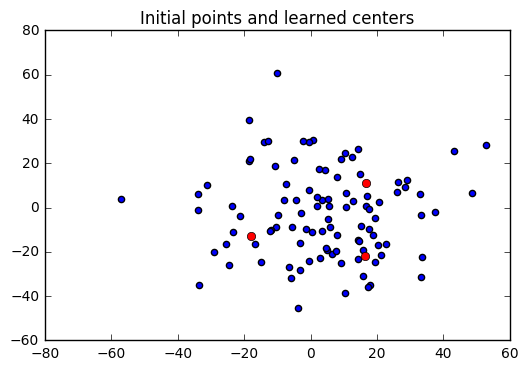

In [155]:
plt.scatter(X[:,0],X[:,1])
plt.hold()
plt.plot(centers[:,0],centers[:,1], 'ro', color = 'red')
plt.title('Initial points and learned centers (red)')

In [137]:
L0 = 2

X = np.array([[1,2,3],[1,2,3]])
wins = np.ones((1,L0))
centers = X[np.random.choice(X.shape[0], L0, replace=False), :]
z = X[np.random.choice(X.shape[0], 1), :]
distances = la.norm(centers - np.ones((L0,1)).dot(z), axis = 1)
distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L0,1)).dot(z), axis = 1))
np.delete(distances,0)
distances[0,:] = distances[0,:] +1  
distances[distances == 0]
np.delete(X, np.argwhere(distances > 0)[:,1], axis = 1)
np.random.choice(X.shape[0], 1)


array([0])

In [ ]:
class fuzzyNetwork()